In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import IPython.display as ipd
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *
from model.generators import *

In [2]:
hist_len = 10
sample_len = 30 #NOTE it includes the hist_len
noise_dim = 1
seq_dim = 3 # (gap, duration, pitch)
scale = 1.
stride = 10
max_pitch = 32
pitch_offset = 37
key = 0

sigma = 1.0
kernel_type = 'truncated'
dyadic_order = 3
n_levels = 10
order = 1

batch_size = 64
activation = 'GELU'
hidden_size = 128
n_layers = 2

In [3]:
with open(f'./data/dataframes/{key}/dfs.pkl', 'rb') as f:
    dfs = pickle.load(f)

Min pitch: 34
Max pitch: 96


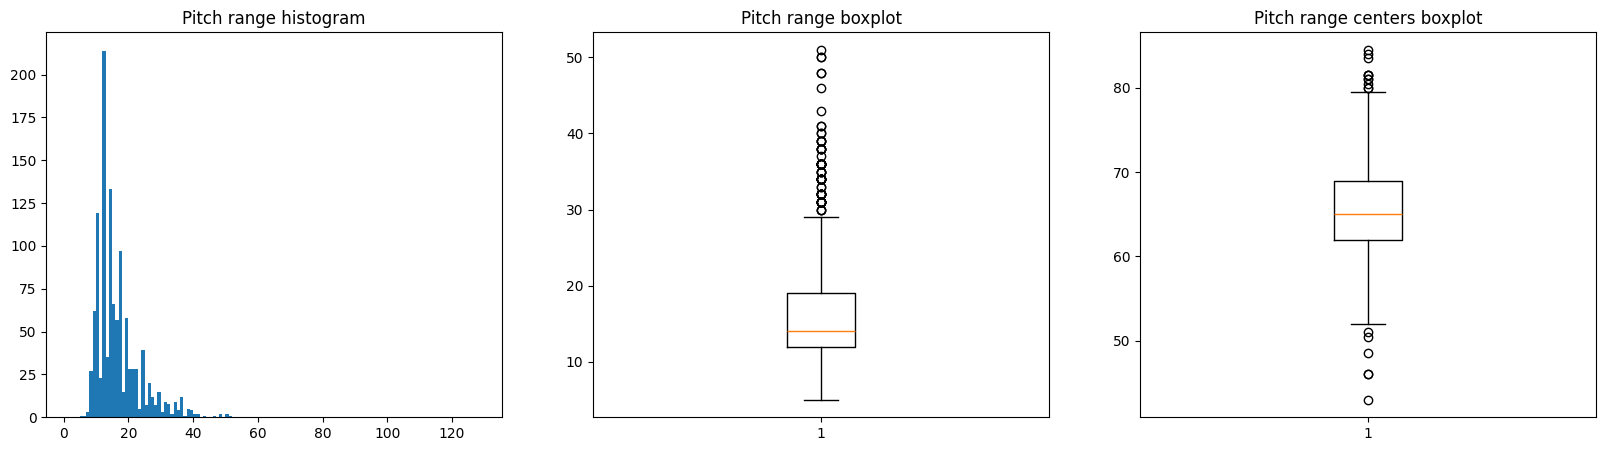

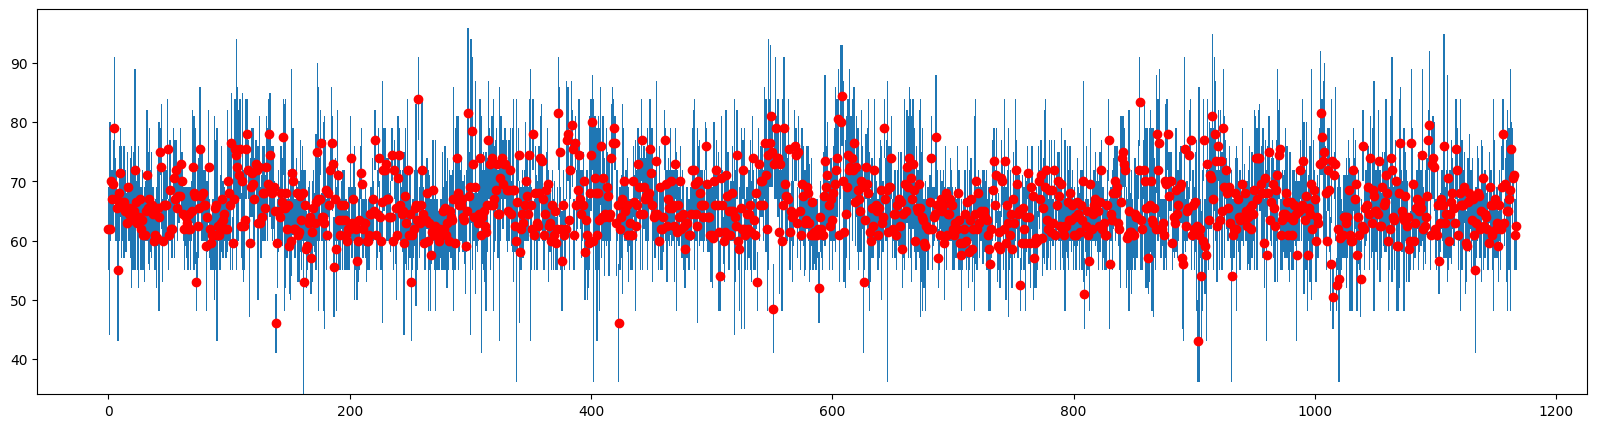

(34, 96)

In [4]:
pitch_range(dfs)

In [5]:
gap_dur_dpitch_dfs = gap_duration_deltapitch_transform(dfs)
dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, 30)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
len(dataset), len(dataloader)

(41394, 324)

In [6]:
generator = LSTMinc(noise_dim, seq_dim, sample_len, hidden_size, n_layers, activation)
generator = generator.cuda()
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

In [7]:
if kernel_type == 'truncated':
    static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
    kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
elif kernel_type == 'pde':
    static_kernel = ksig.sigkernelpde.RationalQuadraticKernel(sigma=sigma, alpha=1.0)
    kernel = ksig.sigkernelpde.SigKernelPDE(static_kernel, dyadic_order)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(30):
    losses = []
    for batch_num, X in enumerate(tqdm(dataloader)):
        X = X.to(device)
        X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])

        noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
        Y = generator(noise, X[:, :hist_len, :])

        Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])
        # print(output.shape, X.shape, X[:, :hist_len, :].shape)

        # compute loss
        optimizer.zero_grad()
        loss = ksig.tests.mmd_loss_no_compile(X_rect, Y_rect, kernel)
        losses.append(loss.item())

        # backpropagate and update weights
        loss.backward()
        optimizer.step()


    # log epoch loss and plot generated samples
    epoch_loss = np.average(losses) # average batch mmd for epoch
    scheduler.step(epoch_loss)
    print(f'Epoch {epoch+1}, loss: {epoch_loss}')

  0%|          | 0/324 [00:00<?, ?it/s]

100%|██████████| 324/324 [06:54<00:00,  1.28s/it]


Epoch 1, loss: 1540.1608849160466


 45%|████▍     | 145/324 [03:05<03:48,  1.28s/it]

In [ ]:
X.device, output.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [ ]:
for x in dataloader:
    x = x.to(device)

    output = generator(x[:, :hist_len, :])

    # noise = torch.randn(x.shape[0], x.shape[1], noise_dim).to(device)
    # output = generator(noise, x[:, :hist_len, :])

    output = torch.cat((x[:, :hist_len, :], output), dim=1)
    break

In [ ]:
sample_idx = np.random.randint(0, batch_size)

In [ ]:
out_dfs = tensor_to_df(output, pitch_offset)
out_dfs[sample_idx]

In [ ]:
in_dfs = tensor_to_df(x, pitch_offset)
in_dfs[sample_idx]

In [ ]:
input_midi = df_to_midi(in_dfs[sample_idx])
output_midi = df_to_midi(out_dfs[sample_idx])

In [ ]:
Fs = 22050
audio_data = input_midi.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)

In [ ]:
audio_data = output_midi.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)